In [3]:

from PIL import Image
import numpy as np
from tqdm import tqdm
import os
from glob import glob

import torch
from torch import nn
from torch.utils import data
import torchvision
import torch.nn.functional as F
from  torch.nn.utils import spectral_norm
from torchvision import models
import torchvision.transforms as transforms
from config import Config as cfg



class GauGanDataset:
    def __init__(self,img_paths):
        self.img_paths = img_paths
        self.img_transforms = transforms.Compose([
            transforms.Resize((cfg.IMAGE_HEIGHT,cfg.IMAGE_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.map_transforms = transforms.Compose([
            transforms.Resize((cfg.IMAGE_HEIGHT,cfg.IMAGE_WIDTH)),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index]).convert("RGB")
        label = Image.open(self.img_paths[index].replace("jpg","bmp"))
        label_img = Image.open(self.img_paths[index].replace("jpg","png")).convert("RGB")
        image = self.img_transforms(image)
        label = self.map_transforms(label).squeeze(0)
        label = (label*255).long()
        label_img = self.img_transforms(label_img)
        label_ohe = F.one_hot(label,num_classes=cfg.NUM_CLASSES).permute(2,0,1).to(image.dtype)
        return {
            "image":image,
            "segmentation_map":label_ohe,
            "label_img": label_img

        }
        

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from glob import glob


In [6]:
img_files = glob(cfg.INPUT_FILES)
np.random.shuffle(img_files)
train_index = int((1-cfg.TEST_SPLIT) * len(img_files))
train_img_files,test_img_files = img_files[:train_index],img_files[train_index:]

In [4]:
train_dataset=GauGanDataset(train_img_files)

In [20]:
# train_dataset[1]["image"].shape,train_dataset[1]["image"].unsqueeze(0).shape
train_dataset[1]["segmentation_map"].shape,train_dataset[1]["segmentation_map"].unsqueeze(0).shape

(torch.Size([12, 256, 256]), torch.Size([1, 12, 256, 256]))

In [25]:
def convert_tensors_to_list_of_images(tensor_list):
    tensor_list = tensor_list.detach().cpu().numpy().astype(np.float)
    tensor_list = np.transpose(tensor_list,(0,2,3,1))
    tensor_list = (tensor_list+1)/2
    tensor_list=(tensor_list*255).astype(np.uint8)
    return tensor_list
# Image.fromarray(convert_tensors_to_list_of_images(train_dataset[1]["image"].unsqueeze(0)).squeeze(0)) 
map = convert_tensors_to_list_of_images(train_dataset[1]["segmentation_map"].unsqueeze(0)).squeeze(0)
map = np.transpose(map,(2,0,1))
map.shape

/tmp/ipykernel_34768/3615947464.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tensor_list = tensor_list.detach().cpu().numpy().astype(np.float)


(12, 256, 256)

In [36]:
Image.fromarray(map[6])
# for img in map:
#     Image.fromarray(img)
np.unique(map[6]),np.unique(train_dataset[1]["segmentation_map"].cpu().numpy())

(array([127, 255], dtype=uint8), array([0., 1.], dtype=float32))

In [44]:
xmax,ymax = Image.open(img_files[0]).size

In [43]:
Image.open(img_files[0].replace("jpg","bmp")).size

(709, 300)

In [56]:
x1max = xmax-cfg.IMAGE_WIDTH
print(x1max)
x1min = 0
x1 = int(np.random.uniform(x1min,x1max))
x2 = x1+cfg.IMAGE_WIDTH
print(x1,x2,x2-x1)

y1max = ymax-cfg.IMAGE_HEIGHT
print(y1max)
y1min = 0
y1 = int(np.random.uniform(y1min,y1max))
y2 = y1+cfg.IMAGE_HEIGHT
print(y1,y2,y2-y1)

453
182 438 256
44
10 266 256


(300, 380)


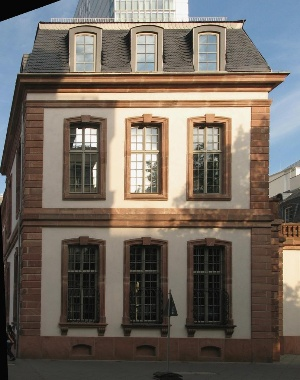

In [21]:
image = Image.open(img_files[0]).convert("RGB")
print(image.size)
image

In [15]:
img_transforms = transforms.Resize(cfg.IMAGE_HEIGHT)
img_transforms(image).size            ,type(img_transforms(image))


((256, 324), PIL.Image.Image)

In [25]:
def random_crop_dimensions(img):
        
        xmax,ymax = img.size
        x1max = xmax-cfg.IMAGE_WIDTH
        # print(x1max)
        x1min = 0
        x1 = int(np.random.uniform(x1min,x1max))
        x2 = x1+cfg.IMAGE_WIDTH
        # print(x1,x2,x2-x1)

        y1max = ymax-cfg.IMAGE_HEIGHT
        # print(y1max)
        y1min = 0
        y1 = int(np.random.uniform(y1min,y1max))
        y2 = y1+cfg.IMAGE_HEIGHT
        # print(x1,x2,x2-x1)
        # print(y1,y2,y2-y1)
        return x1,x2,y1,y2
longest_side_resize = transforms.Resize(256)        

In [22]:
image = longest_side_resize(image)
image.size

(256, 324)

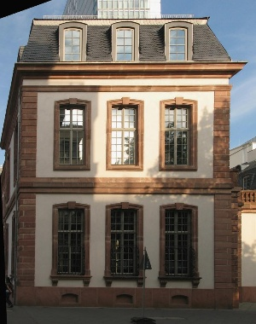

In [23]:
image

In [28]:
x1,x2,y1,y2 = random_crop_dimensions(image)
x1,x2,y1,y2

(0, 256, 59, 315)

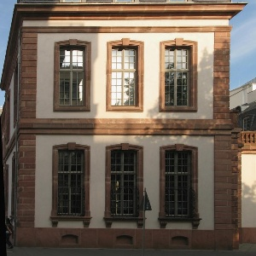

In [33]:
image.crop((x1,y1,x2,y2))